In [2]:
import pandas as pd
import numpy as np
import os 
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
coasm = pd.read_csv('coassembly_resource.csv')
coasm

,tool,coasm_sz,replicate,time(s),mem(kb)
0,megahit,5,1,1955,9062764
1,megahit,5,2,2293,12775868
2,megahit,5,3,1626,9536596
3,megahit,10,1,2666,19440380
4,megahit,10,2,3449,14534364
5,megahit,10,3,4354,16027352
6,megahit,20,1,8060,34270484
7,megahit,20,2,7526,33890248
8,megahit,20,3,6891,38759548
9,megahit,50,1,18042,82538736


In [4]:
cpn = pd.read_csv('copangraph_results_for_python.txt', header=None)
cpn.columns = ['key', 'tool', 'time(s)', 'mem(kb)']
cpn['coasm_sz'] = cpn.key.apply(lambda x: int(x.split('_')[1]))
cpn['replicate'] = cpn.key.apply(lambda x: int(x.split('_')[2]))
cpn.drop('key', axis=1, inplace=True)
cpn.groupby('coasm_sz')['time(s)'].std()/60

coasm_sz
5      0.187824
10     0.418441
20     0.333888
50     0.274030
100    4.700778
Name: time(s), dtype: float64

In [5]:
pe = pd.read_csv('pe_results_for_python.txt', header=None)
pe.columns = ['key', 'sample', 'stage', 'time(s)', 'mem(kb)']
pe['coasm_sz'] = pe.key.apply(lambda x: int(x.split('_')[1]))
pe['replicate'] = pe.key.apply(lambda x: int(x.split('_')[2]))
pe.drop('key', axis=1, inplace=True)
sumarized_pe = pe.groupby(['coasm_sz', 'replicate', 'sample']).apply(lambda x: pd.Series([x['time(s)'].sum(), x['mem(kb)'].max()], index=['total_time', 'max_mem'])).reset_index()
max_pe_mem = sumarized_pe.max_mem.max()
avg_pe_ext_time = sumarized_pe.total_time.mean()
avg_pe_ext_time
pe_parallel_time = sumarized_pe.groupby(['replicate', 'coasm_sz']).apply(lambda x: (avg_pe_ext_time * np.ceil(x.shape[0]/8))).reset_index()
pe_parallel_time .columns = ['replicate', 'coasm_sz', 'time(s)']
plot_dat = pd.merge(pe_parallel_time, cpn, on=['replicate', 'coasm_sz'], suffixes=['_pe', '_cpn'])
plot_dat['mem(kb)'] = plot_dat['mem(kb)'].apply(lambda x: max(x, max_pe_mem))
plot_dat['time(s)'] = plot_dat['time(s)_cpn'] + plot_dat['time(s)_pe']
plot_dat = pd.concat([coasm, plot_dat[['tool', 'coasm_sz', 'replicate', 'time(s)', 'mem(kb)']]])
plot_dat.to_csv('MANUSCRIPT_VERSION_plot_dat.csv')

/burg/pmg/users/ic2465/tmp/ipykernel_352084/2073650326.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sumarized_pe = pe.groupby(['coasm_sz', 'replicate', 'sample']).apply(lambda x: pd.Series([x['time(s)'].sum(), x['mem(kb)'].max()], index=['total_time', 'max_mem'])).reset_index()
/burg/pmg/users/ic2465/tmp/ipykernel_352084/2073650326.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pe_parallel_time

In [6]:
def plot_unlabelled_version(ax, name, tight_layout=True):
    name = os.path.splitext(name)[0]
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    frame1 = plt.gca()
    frame1.legend().set_visible(False)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(f'{name}_UNLBLD.pdf', dpi=1400, bbox_inches='tight')
    plt.savefig(f'{name}_UNLBLD.png', dpi=900, bbox_inches='tight')
    plt.clf()

/burg/pmg/users/ic2465/tmp/ipykernel_2093353/1226443122.py:21: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = mannwhitneyu(copan_vals, coasm_vals, alternative='less')
/burg/pmg/users/ic2465/tmp/ipykernel_2093353/1226443122.py:21: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = mannwhitneyu(copan_vals, coasm_vals, alternative='less')
/burg/pmg/users/ic2465/tmp/ipykernel_2093353/1226443122.py:45: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = mannwhitneyu(copan_vals, coasm_vals, alternative='less')
/burg/pmg/users/ic2465/tmp/ipykernel_2093353/1226443122.py:45: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sam

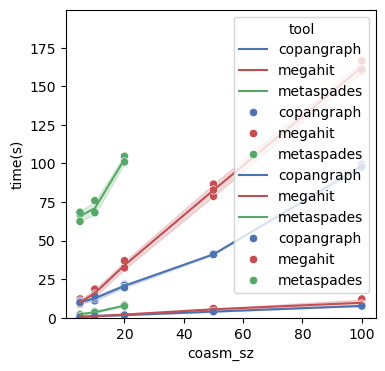

In [ ]:
 # megahit mean genomes per node
plot_dat = plot_dat.sort_values(['coasm_sz', 'replicate'])
from scipy.stats import mannwhitneyu, wilcoxon
plt.figure(figsize=(4,4))
hue_order = ['copangraph','megahit', 'metaspades']
pal = ['#4c72b0', '#c44e52', '#55a868']
ax=sns.lineplot(x=plot_dat.coasm_sz, y=plot_dat['time(s)']/3600, hue=plot_dat.tool, hue_order=hue_order, palette=pal, errorbar='sd')
ax=sns.scatterplot(x=plot_dat.coasm_sz, y=plot_dat['time(s)']/3600, hue=plot_dat.tool, hue_order=hue_order, palette=pal, ax=ax)


mwu = pd.DataFrame(columns = ['tool_a', 'tool_b', 'dataset_size', 'statistic', 'pvalue', 'metric'])
wcx = pd.DataFrame(columns = ['tool_a', 'tool_b', 'dataset_size', 'statistic', 'pvalue', 'metric'])
tool = ['metaspades', 'megahit']
y_max = (plot_dat['time(s)']/3600).max()
ax.set_ybound(0, y_max * 1.2)
#for coasm_sz, g in plot_dat.groupby(by=['coasm_sz']):
#    coasm_sz = coasm_sz[0]
#    for t in tool:
#        copan_vals = g.loc[g.tool == 'copangraph', 'time(s)'].values
#        coasm_vals = g.loc[g.tool == t, 'time(s)'].values
#        res = mannwhitneyu(copan_vals, coasm_vals, alternative='less')
#        if res.pvalue <= 0.05:
#            symbol = '*'
#        mwu.loc[len(mwu), :] = ['copangraph', t, coasm_sz, res.statistic, res.pvalue, 'time']
#        if (len(copan_vals) == len(coasm_vals)):
#            res = wilcoxon(copan_vals, coasm_vals, alternative='less')
#            wcx.loc[len(mwu), :] = ['copangraph', t, coasm_sz, res.statistic, res.pvalue, 'time']
#        symbol = ''
#        multiplier = 1.1 if t == 'metaspades' else 1.05
#        ax.text(coasm_sz, y_max*multiplier, symbol, fontsize=14, color=pal[2] if t == 'metaspades' else pal[1])
ax.set_ylabel('time (hrs)')
name = 'time_resource_plot'
plt.savefig(name + '.pdf', dpi=1400, bbox_inches='tight')
plot_unlabelled_version(ax, name)

ax=sns.lineplot(x=plot_dat.coasm_sz, y=plot_dat['mem(kb)']/2**20, hue=plot_dat.tool, hue_order=hue_order, palette=pal, errorbar='sd')
ax=sns.scatterplot(x=plot_dat.coasm_sz, y=plot_dat['mem(kb)']/2**20, hue=plot_dat.tool, hue_order=hue_order, palette=pal, ax=ax)
y_max = (plot_dat['mem(kb)']/2**20).max()
ax.set_ybound(0, y_max * 1.2)
#for coasm_sz, g in plot_dat.groupby(by=['coasm_sz']):
#    coasm_sz = coasm_sz[0]
#    for t in tool:
#        copan_vals = g.loc[g.tool == 'copangraph', 'time(s)'].values
#        coasm_vals = g.loc[g.tool == t, 'time(s)'].values
#        res = mannwhitneyu(copan_vals, coasm_vals, alternative='less')
#        if res.pvalue <= 0.05:
#            symbol = '*'
#        mwu.loc[len(mwu), :] = ['copangraph', t, coasm_sz, res.statistic, res.pvalue, 'mem']
#        if (len(copan_vals) == len(coasm_vals)):
#            res = wilcoxon(copan_vals, coasm_vals, alternative='less')
#            wcx.loc[len(mwu), :] = ['copangraph', t, coasm_sz, res.statistic, res.pvalue, 'mem']
#        symbol = ''
#        if res.pvalue <= 0.05:
#            symbol = '*'
#        multiplier = 1.1 if t == 'metaspades' else 1.05
#        ax.text(coasm_sz, y_max*multiplier, symbol, fontsize=14, color=pal[2] if t == 'metaspades' else pal[1])

#mwu.to_csv('mwu.csv')
#wcx.to_csv('wcox.csv')
ax.set_ylabel('memory (GB)')
name = 'mem_resource_plot'
plt.savefig(name + '.pdf', dpi=1400, bbox_inches='tight')
plot_unlabelled_version(ax, name)




#ax=sns.lineplot(x=cpn.coasm_sz, y=cpn['mem(kb)']/2**20, errorbar='sd')
#ax=sns.scatterplot(x=cpn.coasm_sz, y=cpn['mem(kb)']/2**20, ax=ax)
#name = 'copan_mem_tgm_only'
#ax.set_ylabel('memory (GB)')
#plt.savefig(name + '.pdf', dpi=1400, bbox_inches='tight')
#plot_unlabelled_version(ax, name)
#ax=sns.lineplot(x=cpn.coasm_sz, y=cpn['time(s)']/3600, errorbar='sd')
#ax=sns.scatterplot(x=cpn.coasm_sz, y=cpn['time(s)']/3600, ax=ax)
#name = 'copan_time_tgm_only'
#ax.set_ylabel('time (hrs)')
#plt.savefig(name + '.pdf', dpi=1400, bbox_inches='tight')
#plot_unlabelled_version(ax, name)